In [3]:
import numpy as np

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [5]:
import os
import random
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [6]:
## now we have already stored the neg images into the 
## data\NEG_IMG folder 


In [7]:
## now accessing the actual image using the opencv

In [8]:
import uuid

In [9]:
os.path.join('data/AUC_IMG', '{}.jpg'.format(uuid.uuid1()))

'data/AUC_IMG\\b372ae5d-693e-11f0-b0d6-f7af4675421c.jpg'

In [10]:
cap = cv.VideoCapture(0)

In [ ]:
while cap.isOpened():
    ret, frame = cap.read()

    frame = frame[150:150+256, 200:200+256, :]

    # collecting the anchors
    if cv.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join('data/AUC_IMG', '{}.jpg'.format(uuid.uuid1()))
        cv.imwrite(imgname, frame)

    # collecting the postivies 
    if cv.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join('data/POS_IMG', '{}.jpg'.format(uuid.uuid1()))
        cv.imwrite(imgname, frame)

    cv.imshow('Image Collection', frame)

    if cv.waitKey(1) & 0XFF == ord('q'):
        break 
cap.release()
cv.destroyAllWindows()

In [12]:
## creating the directories for the images 
anchor = tf.data.Dataset.list_files("data/AUC_IMG"+'/*.jpg').take(300)

In [13]:
len(anchor)

300

In [14]:
dir_test = anchor.as_numpy_iterator()

In [15]:
dir_test.next()

b'data\\AUC_IMG\\5aba285d-690a-11f0-a852-f7af4675421c.jpg'

In [16]:
positive = tf.data.Dataset.list_files('data/POS_IMG'+'/*jpg').take(300)

In [17]:
len(positive)

197

In [18]:
negative = tf.data.Dataset.list_files("data/neg_image"+'/*jpg').take(300)

In [19]:
len(negative)

300

In [20]:
## Pre Processing the image

In [21]:
def preprocess(file_path):

    #Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Loading in the image
    img = tf.io.decode_jpeg(byte_img)
    # Pre processing steps - resizing the image to be 100*100*3
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img

In [22]:
## create labelled dataset 

In [23]:
## (anchor, positive) = 1,1,1,1,1
## (anchor, negative) = 0,0,0,0,0

In [24]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [25]:
samples = data.as_numpy_iterator()

In [26]:
example = samples.next()

In [27]:
example

(b'data\\AUC_IMG\\aa268a81-690a-11f0-8379-f7af4675421c.jpg',
 b'data\\POS_IMG\\e4c9b8e5-690a-11f0-a4c1-f7af4675421c.jpg',
 1.0)

In [28]:
## Build Train and test Partition 

In [29]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [30]:
res = preprocess_twin(*example)

In [31]:
res[0]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.80067295, 0.7967514 , 0.78890824],
        [0.8008627 , 0.79694116, 0.7812549 ],
        [0.8035294 , 0.7996078 , 0.78392154],
        ...,
        [0.8561568 , 0.8718431 , 0.87576467],
        [0.85911685, 0.8748031 , 0.8787247 ],
        [0.85968626, 0.8753725 , 0.8792941 ]],

       [[0.7992361 , 0.79531455, 0.7874714 ],
        [0.80045336, 0.7965318 , 0.7826055 ],
        [0.80232936, 0.7984078 , 0.7827215 ],
        ...,
        [0.85390586, 0.8655921 , 0.87084705],
        [0.8601568 , 0.8718431 , 0.87709796],
        [0.8606274 , 0.87231374, 0.8775686 ]],

       [[0.79607844, 0.7921569 , 0.78431374],
        [0.80013335, 0.7962118 , 0.788102  ],
        [0.7961176 , 0.79219604, 0.7772157 ],
        ...,
        [0.85882354, 0.8627451 , 0.87058824],
        [0.8627451 , 0.8666667 , 0.8745098 ],
        [0.863051  , 0.86697257, 0.8748157 ]],

       ...,

       [[0.07286282, 0.09247066, 0.11600007],
        [0.07

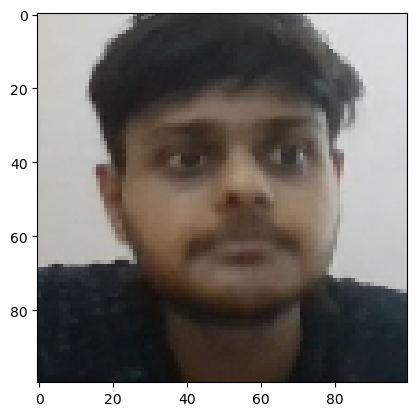

In [32]:
plt.imshow(res[0])

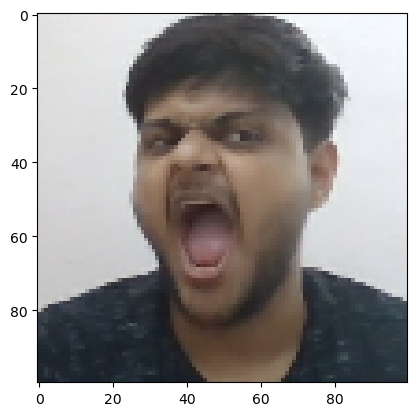

In [33]:
plt.imshow(res[1])

In [34]:
res[2]

1.0

In [35]:
# Building dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [36]:
samples = data.as_numpy_iterator()

In [37]:
len(samples.next())

3

In [38]:
samp = samples.next()

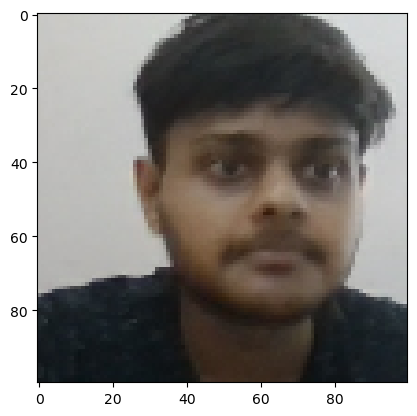

In [39]:
plt.imshow(samp[0])

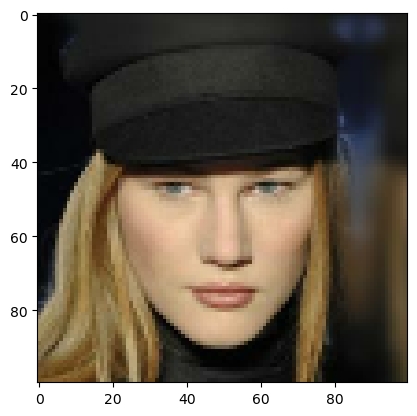

In [40]:
plt.imshow(samp[1])

In [41]:
samp[2]

0.0

In [42]:
##training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [43]:
train_samples = train_data.as_numpy_iterator()

In [44]:
train_samples = train_samples.next()

In [45]:
len(train_samples)

3

In [46]:
len(train_samples[0])

16

In [47]:
## Testing data 
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [48]:
## Build the embedding layer
inp = Input(shape = (105, 105, 3), name = 'input_layer')

In [49]:
inp

<KerasTensor shape=(None, 105, 105, 3), dtype=float32, sparse=False, name=input_layer>

In [50]:
c1 = Conv2D(64, (10, 10), activation = 'relu')(inp)

In [51]:
m1 = MaxPooling2D(64, (2,2), padding = 'same')(c1)

In [52]:
m1

<KerasTensor shape=(None, 48, 48, 64), dtype=float32, sparse=False, name=keras_tensor_1>

In [53]:
c2 = Conv2D(128, (7, 7), activation = 'relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)

# third Block 
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

# Final embedding block
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [54]:
mod = Model(input=[inp], outputs=[d1], name = 'embedding')

ValueError: Unrecognized keyword arguments passed to Model: {'input': [<KerasTensor shape=(None, 105, 105, 3), dtype=float32, sparse=False, name=input_layer>], 'outputs': [<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_8>]}

In [55]:
mod.summary()

NameError: name 'mod' is not defined

In [56]:
## Build the embedding layer
def make_embedding():
    inp = Input(shape = (100, 100, 3), name = 'input_layer')

    # First Block
    c1 = Conv2D(64, (10, 10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding = 'same')(c1)

    # Second Block 
    c2 = Conv2D(128, (7, 7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)

    # third Block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=inp , outputs=d1 , name='embedding')

In [57]:
embedding = make_embedding()

In [58]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
## making of a distance layer
class L1Dist(Layer):

    # init method - inheritance 
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, inputs):
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)

In [60]:
siamese_layer = L1Dist()

In [61]:
input_image = Input(name = 'input_img', shape=(100, 100, 3))
validation_image = Input(name = 'validation_img', shape = (100, 100, 3))

In [62]:
input_embedding = embedding(input_image)

In [63]:
val_embedding = embedding(validation_image)

In [64]:
siamese_layer([input_embedding, val_embedding])

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_20>

In [65]:
input_image = Input(name = 'input_img', shape=(100, 100, 3))

# Validation image in the network
validation_image = Input(name = 'validation_image', shape=(100, 100, 3))

# combine siames distance components 
siamese_layer = L1Dist()
siamese_layer._name = 'distance'
distances = siamese_layer([embedding(input_image), embedding(validation_image)])

# Classification layer 
classifier = Dense(1, activation = 'sigmoid')(distances)

In [66]:
siamese_network = Model(inputs=[input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')

In [67]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
## making of the siamese model
def make_siamese_model():

    #Anchor image input in the network
    input_image = Input(name = 'input_img', shape=(100, 100, 3))

    # Validation image in the network
    validation_image = Input(name = 'validation_image', shape=(100, 100, 3))

    # combine siames distance components 
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer([embedding(input_image), embedding(validation_image)])

    # Classification layer 
    classifier = Dense(1, activation = 'sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')



In [69]:
siamese_model = make_siamese_model()

In [70]:
## setting up the loss function and optimiser

binary_cross_loss = tf.losses.BinaryCrossentropy() # type: ignore

In [71]:
# optimiser 
opt = tf.keras.optimizers.Adam(1e-4) # type: ignore

In [72]:
## establishing the checkpoints 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt , siamese_model = siamese_model)

In [73]:
test_batch = train_data.as_numpy_iterator()

In [74]:
batch_1 = test_batch.next()

In [75]:
type(batch_1)

tuple

In [76]:
X = batch_1[:2]

In [77]:
len(X[0])

16

In [78]:
np.array(X).shape
# 2 values we are selecting 
# 16 batches 
# 100 * 100 dimension 
# 3 color channels

(2, 16, 100, 100, 3)

In [79]:
@tf.function
def trian_step(batch):

    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get labels 
        y = batch[2]

        # Forward Pass
        yhat = siamese_model(X, training = True)
        # Calculate loss 
        loss = binary_cross_loss(y, yhat)
    print(loss)
    
    # Calculate gradients 
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siames model 
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables)) # type: ignore
    return loss

In [80]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch 
        for idx, batch in enumerate(data):
            # Run train step here
            trian_step(batch)
            progbar.update(idx+1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix= checkpoint_prefix)


In [121]:
EPOCHS = 10
train(train_data, EPOCHS)


 Epoch 1/10
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
21/22 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/stepTensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step

 Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step

 Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step

 Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step

 Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step

 Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step

 Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step

 Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step

 Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step

 Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step


In [122]:
from tensorflow.keras.metrics import Precision, Recall

In [123]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [124]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


In [125]:
y_hat

array([[9.9995458e-01],
       [8.5476589e-01],
       [3.1144687e-08],
       [1.4974770e-08],
       [1.6398977e-02],
       [1.0450933e-06],
       [6.2640572e-07],
       [7.4613666e-08],
       [1.8317162e-07],
       [1.5475543e-08],
       [1.9513359e-07],
       [1.9134642e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999815e-01]], dtype=float32)

In [126]:
# Post processing the results 
y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]

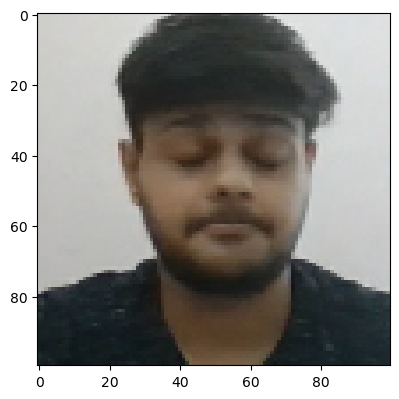

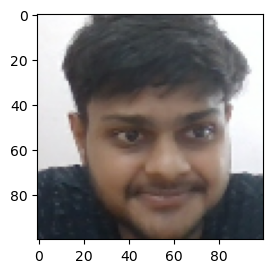

In [127]:
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
plt.imshow(test_input[0])
plt.show()
plt.subplot(1, 2, 1)
plt.imshow(test_val[0])
plt.show()

In [128]:
m = Precision()

m.update_state(y_true, y_hat)

m.result().numpy()

1.0

In [129]:
m = Recall()

m.update_state(y_true, y_hat)

m.result().numpy()

1.0

In [130]:
## saving the model 

In [131]:
siamese_model.save('siamesemodel1.h5')

In [132]:
L1Dist

__main__.L1Dist

In [133]:
model = tf.keras.models.load_model('siamesemodel1.h5', 
                                   custom_objects = {'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [134]:
tf.keras.models.load_model??

Signature:
tf.keras.models.load_model(
    filepath,
    custom_objects=None,
    compile=True,
    safe_mode=True,
)
Source:   
@keras_export(["keras.saving.load_model", "keras.models.load_model"])
def load_model(filepath, custom_objects=None, compile=True, safe_mode=True):
    """Loads a model saved via `model.save()`.

    Args:
        filepath: `str` or `pathlib.Path` object, path to the saved model file.
        custom_objects: Optional dictionary mapping names
            (strings) to custom classes or functions to be
            considered during deserialization.
        compile: Boolean, whether to compile the model after loading.
        safe_mode: Boolean, whether to disallow unsafe `lambda` deserialization.
            When `safe_mode=False`, loading an object has the potential to
            trigger arbitrary code execution. This argument is only
            applicable to the Keras v3 model format. Defaults to `True`.

    Returns:
        A Keras model instance. If the or

In [135]:
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


array([[9.9995458e-01],
       [8.5476589e-01],
       [3.1144687e-08],
       [1.4974770e-08],
       [1.6398977e-02],
       [1.0450933e-06],
       [6.2640572e-07],
       [7.4613666e-08],
       [1.8317162e-07],
       [1.5475543e-08],
       [1.9513359e-07],
       [1.9134642e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999815e-01]], dtype=float32)

In [136]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_4 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [137]:
## Real Time test 

In [138]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        ## Make predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    print(results)

    return results, verified


In [139]:
## openCV Real Time Verification 
cap = cv.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    frame = frame[150:150+256, 200:200+256, :]
    
    cv.imshow('Verification', frame)

    if cv.waitKey(10) & 0xFF == ord('v'):
        # save input images to application_data/input_image folder
        cv.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'),frame)
        # Run verifications 
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
    
    if cv.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━

In [119]:
results

[array([[0.49828812]], dtype=float32),
 array([[0.49896342]], dtype=float32),
 array([[0.4992121]], dtype=float32),
 array([[0.49912015]], dtype=float32),
 array([[0.4989781]], dtype=float32),
 array([[0.49807197]], dtype=float32),
 array([[0.49807197]], dtype=float32),
 array([[0.4991726]], dtype=float32),
 array([[0.4995507]], dtype=float32),
 array([[0.49933395]], dtype=float32),
 array([[0.49903956]], dtype=float32),
 array([[0.49844494]], dtype=float32),
 array([[0.49854702]], dtype=float32),
 array([[0.4984561]], dtype=float32),
 array([[0.49872205]], dtype=float32),
 array([[0.49879116]], dtype=float32),
 array([[0.49841005]], dtype=float32),
 array([[0.4981942]], dtype=float32),
 array([[0.4989525]], dtype=float32),
 array([[0.49889255]], dtype=float32),
 array([[0.49888647]], dtype=float32),
 array([[0.49880287]], dtype=float32),
 array([[0.49880874]], dtype=float32),
 array([[0.49872482]], dtype=float32),
 array([[0.4993629]], dtype=float32),
 array([[0.49854377]], dtype=floa